In [38]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose whether to use gpu or cpu


In [40]:
# data_dir = r'C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00AgNO3_mole_fraction\Outputs_Grayscale_Labelled_Images_Sizes\size_folder'  #path to the folder containing the images
data_dir = r'C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00AgNO3_mole_fraction\size_range\7-11'
# data_dir = r'C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00AgNO3_mole_fraction\Outputs_Grayscale_Labelled_Images_Sizes\size_folder\second_half'
# from google.colab import drive
# drive.mount('/content/drive')
# data_dir = "/content/drive/My Drive/size_folder" #colab path
# data_dir = r'C:\Users\Chappyyyyyy\Documents\size_folder' #path to folder for chappy computer


In [41]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

# dataset with cutsize 
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))])
        self.labels = [self.extract_label(img) for img in self.images]
        self.cuttime = [self.extract_cuttime(img) for img in self.images]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        cuttime = self.cuttime[idx]
        return image, label, cuttime

    def extract_label(self, img_name):
        # Assuming that the label is part of the filename before the first underscore
        label = float(img_name[-17:-5]) #this is the right code
        # label = img_name
        return label
    
    def extract_cuttime(self, img_name):
        cuttime = float(img_name.split("t-")[1].split("_")[0])
        return cuttime

In [42]:
data_transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.45), (0.225))]) 

custom_dataset = CustomImageDataset(root_dir=data_dir, transform=data_transform)

# # Accessing the data
# for img, label in custom_dataset:
#     print(f"Image shape: {img.shape}, Label: {label}")

print(len(custom_dataset))
# train_set, val_set, test_set = random_split(custom_dataset, [int(len(custom_dataset)*0.75), int(len(custom_dataset)*0.15), int(len(custom_dataset)*0.100056)]) #splits data into training, validation and test sets
train_set, test_set = random_split(custom_dataset, [int(len(custom_dataset)*0.75), int(len(custom_dataset)*0.25003)])
print(len(train_set))
# print(len(val_set))
print(len(test_set))

5472
4104
1368


In [43]:
#hyper parameters
# num_epochs = 30
num_epochs = 60
batch_size = 1
learning_rate = 0.0005
# learning_rate = 0.001

train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# val = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test = DataLoader(test_set, batch_size=batch_size, shuffle=False)

for (images, labels, cuttime) in train:
    print(labels.item())
    print(cuttime.item())
    break

for i in train:
    print(i)
    break

8.34423
6.0
[tensor([[[[-2., -2., -2.,  ..., -2., -2., -2.],
          [-2., -2., -2.,  ..., -2., -2., -2.],
          [-2., -2., -2.,  ..., -2., -2., -2.],
          ...,
          [-2., -2., -2.,  ..., -2., -2., -2.],
          [-2., -2., -2.,  ..., -2., -2., -2.],
          [-2., -2., -2.,  ..., -2., -2., -2.]]]]), tensor([8.2751], dtype=torch.float64), tensor([159.], dtype=torch.float64)]


In [44]:
class ConvNet(nn.Module): # note need to find out image size
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1,8,10, padding='same') #in_channels, out_channels, kernel_size
        self.normalise1 = nn.BatchNorm2d(8)
        # self.pool = nn.MaxPool2d(5,5) #kernel_size, stride (shift x pixel to the right)
        self.pool1 = nn.AvgPool2d(10, stride=10)
        # self.pool1 = nn.MaxPool2d(10, stride=10)
        self.conv2 = nn.Conv2d(8, 16, 10, padding='same')
        self.normalise2 = nn.BatchNorm2d(16)
        self.pool2 = nn.AvgPool2d(2, stride=2)
        # self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 10, padding='same')
        self.normalise3 = nn.BatchNorm2d(32) 
        self.conv4 = nn.Conv2d(32, 32, 10, padding='same')
        # self.fc1 = nn.Linear(16*3*3, 120) # 3x3 is the size of the image after 2 conv layers, 16 is the number of channels, 120 is the number of nodes in the hidden layer
        # self.fc2 = nn.Linear(120,84)
        # self.fc3 = nn.Linear(60, 1)
        self.fc = nn.Linear(32*5*5, 1)
        self.fc1 = nn.Linear(32*5*5+5, 400)
        self.fc2 = nn.Linear(400,200)
        self.fc3 = nn.Linear(200,1)
        self.dropout = nn.Dropout(0.1)
        self.cutFC1 = nn.Linear(1, 24)
        self.cutFC2 = nn.Linear(24, 24)
        self.cutFC3 = nn.Linear(24, 1)
        self.cutFC = nn.Linear(1, 1)

    def forward(self, x, y):
        x = self.pool1(F.relu(self.normalise1(self.conv1(x)))) 
        x = self.pool2(F.relu(self.normalise2(self.conv2(x)))) 
        x = F.relu(self.normalise3(self.conv3(x)))
        x = F.relu(self.normalise3(self.conv4(x)))
        x = F.relu(self.normalise3(self.conv4(x)))
        x = x.view(-1, 32*5*5)  #flatten
        # y = F.relu(self.cutFC1(y))
        # y = F.relu(self.cutFC2(y))
        # y = self.cutFC3(y)
        y = self.cutFC(y)
        y = y.view(-1, 1).repeat(1,5)
        # print(y)
        z = torch.cat((x,y), dim=1)
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = self.fc3(z)
        # z = self.fc(z)
        
        return z

In [45]:
model = ConvNet().to(device)

# loss and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
#training loop
n_total_steps = len(train)
for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels, cuttimes) in enumerate(train):
        images = images.to(device)
        labels = labels.to(device)
        cuttimes = cuttimes.to(device).float()

        #forward
        outputs = model(images, cuttimes)
        # print(labels)
        labels = labels.float() #this is the right code
        # labels = float(labels[0][-17:-5])
        loss = criterion(outputs, labels)

        #backward
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        # if (i+1) % 1000 ==0:
        # print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
        total_loss += loss.item()
    print(f'epoch {epoch+1}/{num_epochs}, average loss = {total_loss/len(train):.4f}')
            

print("Finished Training")

epoch 1/60, average loss = 1.8330
epoch 2/60, average loss = 1.3106
epoch 3/60, average loss = 1.1445
epoch 4/60, average loss = 0.9157
epoch 5/60, average loss = 0.7729
epoch 6/60, average loss = 0.7326
epoch 7/60, average loss = 0.6734
epoch 8/60, average loss = 0.6017
epoch 9/60, average loss = 0.5811
epoch 10/60, average loss = 0.5459
epoch 11/60, average loss = 0.5280
epoch 12/60, average loss = 0.4982
epoch 13/60, average loss = 0.4635
epoch 14/60, average loss = 0.4671
epoch 15/60, average loss = 0.4481
epoch 16/60, average loss = 0.4416
epoch 17/60, average loss = 0.4079
epoch 18/60, average loss = 0.3992
epoch 19/60, average loss = 0.4038
epoch 20/60, average loss = 0.3906
epoch 21/60, average loss = 0.3555
epoch 22/60, average loss = 0.3618
epoch 23/60, average loss = 0.3674
epoch 24/60, average loss = 0.3640
epoch 25/60, average loss = 0.3531
epoch 26/60, average loss = 0.3459
epoch 27/60, average loss = 0.3160
epoch 28/60, average loss = 0.3328
epoch 29/60, average loss = 0

RMSE = tensor([0.4936], dtype=torch.float64)


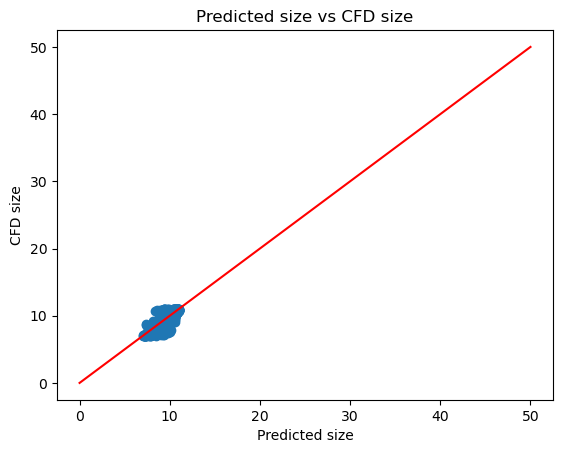

In [46]:
with torch.no_grad(): # no need to calculate gradient
    squared_difference = 0
    predicted_size_data = []
    CFD_size_data = []
    for images, labels, cuttimes in test:
        images = images.to(device)
        labels = labels.to(device)
        cuttimes = cuttimes.to(device).float()
        outputs = model(images, cuttimes)
        predictions = float(outputs[0,0])
        predicted_size_data.append(predictions)
        CFD_size_data.append(float(labels))

        squared_difference += (predictions - labels) ** 2
    
    rmse = torch.sqrt(squared_difference / len(test))
    print(f'RMSE = {rmse}')
    plt.scatter(predicted_size_data, CFD_size_data)
    x = np.linspace(0, 50, 100)
    plt.plot(x, x, '-r')
    plt.xlabel('Predicted size')
    plt.ylabel('CFD size')
    plt.title('Predicted size vs CFD size')
    plt.show()

In [ ]:
#consideration
# 1. change the number of layers
# 2. use GELU instead of ReLU